In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import pathlib as pl
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

In [42]:
width = 7.08
height = 0.7
figsize = (width, height)
ticklabelsize = 6
labelsize = 6
titlesize = labelsize

# Set rcParams for plotting
mpl.rc("xtick", labelsize=ticklabelsize)
mpl.rc("ytick", labelsize=ticklabelsize)
mpl.rc("axes", labelsize=labelsize, titlesize=titlesize, linewidth=0.5)

mar_t = 0.5
mar_b = 2.5
mar_r=0.1775
mar_l=0.075
wspace=0.3


def format_fig(
    fig, figsize=figsize, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, mar_b=mar_b, **kwargs
):
    """Adjust margins of subplots using figsize"""
    height, width = figsize
    fig.set_size_inches(figsize)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs
    )

    for ax in fig.get_axes():
        ax.tick_params(which="both", length=1.0, width=0.5)

In [4]:
cmax = 50

JG075B = (
    QuantStudio(
        data_pth / "JG075B L-MMMMx blocker tripartite competition separate.xlsx",
        "JG075B",
    )
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("HEX")
)

# Denote reaction conditions
JG075B.reactions.wide = (
    JG075B.reactions.wide.replace(
        {
            "Target": {
                "S075_WTFAM": "S075_WT",
                "S075_WTHEX": "S075_WT",
                "S075_SNVFAM": "S075_SNV",
                "S075_SNVHEX": "S075_SNV",
            }
        }
    )
    .merge(
        pd.read_csv(data_pth / "JG075B Plate Map.csv")
    )  # [['Sample','WT Conc','Competitor Conc','Primer Conc']])
    .assign(lg10_Blocker=lambda df: np.log10(df["Blocker μM"]))
    .replace({"lg10_Blocker": {-np.inf: -2}})
    .drop(columns=["CT"])
)


JG075B.reactions.neaten()
JG075B.extract_endpoints(cmax=cmax)
endpoints = JG075B.endpoints
JG075B.reactions

/home/john/mambaforge/envs/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Sample,Task,Comments,Reaction,Blocker,Blocker μM,Configuration,WellName,lg10_Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,1,0.001097,0.003485
1,JG075B,1,S075_WT,8.0,False,A1,100000000.0,HEX,JG075B_001,STANDARD,,1,L-MMMMx,3.162278,2+2,A1,0.5,1,-0.000695,0.001712
2,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,2,0.000667,0.002776
3,JG075B,1,S075_WT,8.0,False,A1,100000000.0,HEX,JG075B_001,STANDARD,,1,L-MMMMx,3.162278,2+2,A1,0.5,2,-0.000553,0.001408
4,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,3,-0.002053,0.000296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,88,-1.717209,1.278983
44636,JG075B,376,S075_SNV,1.0,False,P16,10.0,FAM,JG075B_376,STANDARD,,494,L-MMMMx,0.000000,7+2,P16,-2.0,89,0.453918,0.440494
44637,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,89,-1.735487,1.292101
44638,JG075B,376,S075_SNV,1.0,False,P16,10.0,FAM,JG075B_376,STANDARD,,494,L-MMMMx,0.000000,7+2,P16,-2.0,90,0.458040,0.444762


In [5]:
target_palette = list(zip(["S075_WT", "S075_SNV"], ["Purples", "Greens"]))

In [6]:
(np.log10(JG075B.reactions.data["Blocker μM"]) % 0.5).isin([0., np.nan])

/home/john/mambaforge/envs/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0        True
1        True
2        True
3        True
4        True
         ... 
44635    True
44636    True
44637    True
44638    True
44639    True
Name: Blocker μM, Length: 44640, dtype: bool

Saving fig_ED1Dii__slow_wombat in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


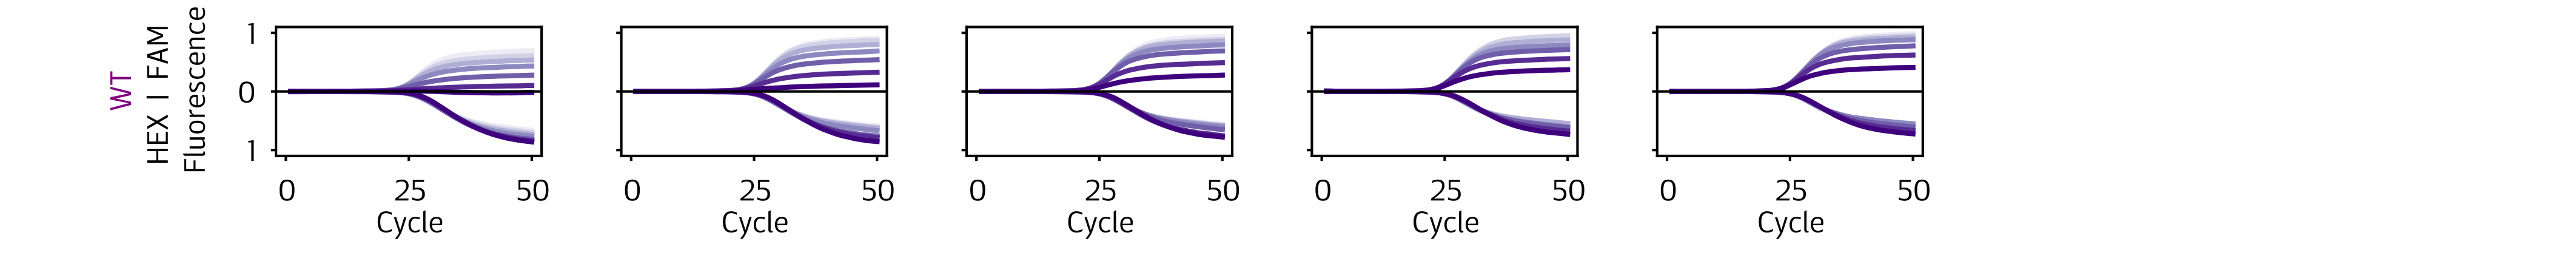

Saving fig_ED1Di__fast_vole in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


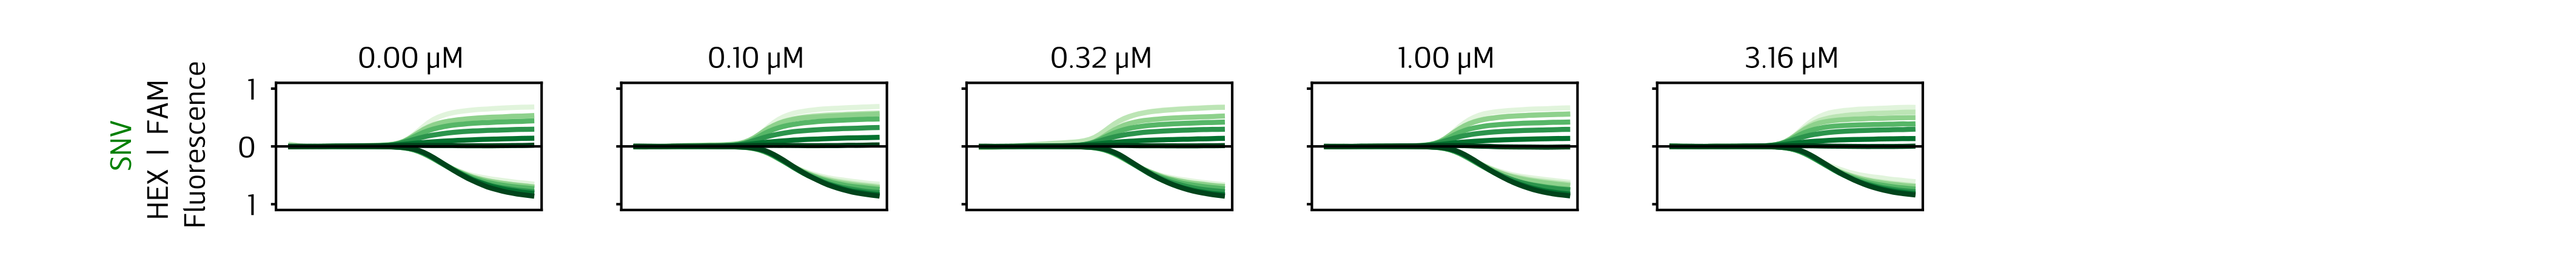

In [52]:
hue = "lg10_Copies"
extent = np.max(np.abs(JG075B.reactions.wide[hue]))
norm = mpl.colors.Normalize(
    vmin=JG075B.reactions.wide[hue].min(), vmax=JG075B.reactions.wide[hue].max()
)

blocker = "L-MMMMx"
configs = ["2+2", "7+2"]

config = "2+2"

for target, palette in target_palette:
    data = JG075B.reactions.data

    with np.errstate(divide='ignore'):
        data = data[
            (data.Cycle <= cmax) & (data.Configuration == config) & (data.Target == target) & 
            (np.log10(data["Blocker μM"]) % 0.5).isin([0., np.nan])  # Half-log intervals
        ]

    g = sns.relplot(
        data=data,
        x="Cycle",
        y="Fluorescence",
        col="Blocker μM",
        units="Reaction",
        hue=hue,
        legend=False,
        palette=palette,
        hue_norm=norm,
        kind="line",
        estimator=None,
        height=2,
        aspect=1.0,
        linewidth=1,
        facet_kws={"margin_titles": True, "despine": False},
    )

    g.refline(y=0, color="k", linestyle="-", linewidth=0.5)
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax + 2], ylabel='', yticks=[-1, 0, 1], yticklabels=[1, 0, 1])
    # g.set_titles(col_template="", row_template="")
    # plt.tight_layout()
    
    fig = plt.gcf()

    ax = fig.axes[0]

    txt_kws = dict(
        y=0,
        fontsize=labelsize,
        transform=ax.transData,
        ha="right",
        va="center",
        rotation=90)

    ax.text(
        x=-15,
        s='Fluorescence',
        color = "k",
        **txt_kws
    )

    ax.text(
        x=-22.5,
        s='HEX  |  FAM',
        color = "k",
        **(txt_kws | {'y':-0.10})
    )

    if target == "S075_WT":

        g.set_titles(col_template="")
        g.set(xticks=[0, 25, 50])
        g.set_xlabels('Cycle', fontsize=labelsize, labelpad=0.5)

        ax.text(
            x=-30,
            s='WT',
            color = "purple",
            **txt_kws
        )

        
        
        format_fig(
            fig,
            figsize=(width, height),
            mar_t=0.75,
            mar_b=2.75,
            wspace=wspace
        )
    else:
        g.set_titles(col_template="{col_name:.2f} μM", fontsize=labelsize, pad=labelsize*0.5)
        g.set(xticks=[])
        g.set_xlabels('')

        ax.text(
            x=-30,
            s='SNV',
            color = "green",
            **txt_kws
        )

        
        
        format_fig(
            fig,
            figsize=(width, height),
            mar_t=2.3,
            mar_b=1.25,
            wspace=wspace
        )
    

    alias = {"S075_WT": "slow_wombat", "S075_SNV": "fast_vole"}[target]

    savefig(plt.gcf(), alias=alias)